
# 1. 
## Import packages

In [535]:
# This first set of packages include Pandas, for data manipulation, numpy for mathematical computation and matplotlib & seaborn, for visualisation.
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

# Statistical packages used for transformations
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
print('Statistical packages imported!')

# Metrics used for measuring the accuracy and performance of the models
#from sklearn import metrics
#from sklearn.metrics import mean_squared_error
print('Metrics packages imported!')

# Algorithms used for modeling
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
print('Algorithm packages imported!')

# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!
Statistical packages imported!
Metrics packages imported!
Algorithm packages imported!
Pipeline and preprocessing packages imported!
Model selection packages imported!
My colours are ready! :)
Deprecation warning will be ignored!



# 2. 
## Load data

- We can drop the 'Id' columns from the training and test datasets as they are redundant.

In [536]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' column as it's redundant for modeling
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print(train.shape)
print(test.shape)
# train.head()

(1460, 80)
(1459, 79)



# 3. 
## Data preparation


### 3.1 - Remove outliers

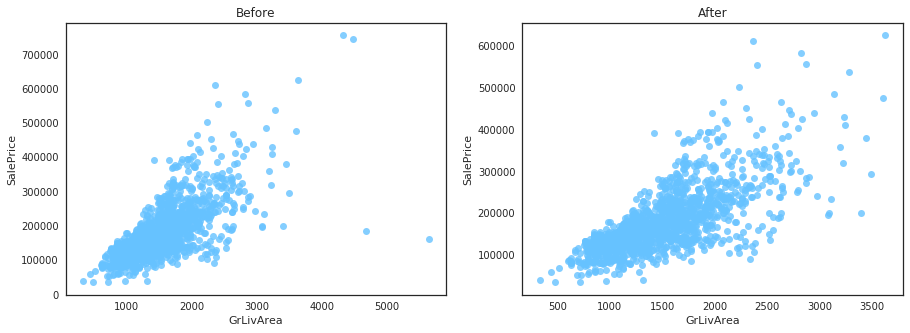

In [537]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("After")


### 3.2 - Treat missing values


**If you have missing values, you have two options**:
- Delete the entire row
- Fill the missing entry with an imputed value

In order to treat this dataset, first of all I will create a dataset of the training and test data in order to make changes consistent across both. Then, I will cycle through each feature with missing values and treat them individually based on the data description, or my judgement.

In [538]:
# First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

# Also save the target value, as we will remove this
y_train = train.SalePrice.values

# concatenate training and test data into all_data
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2915, 79)


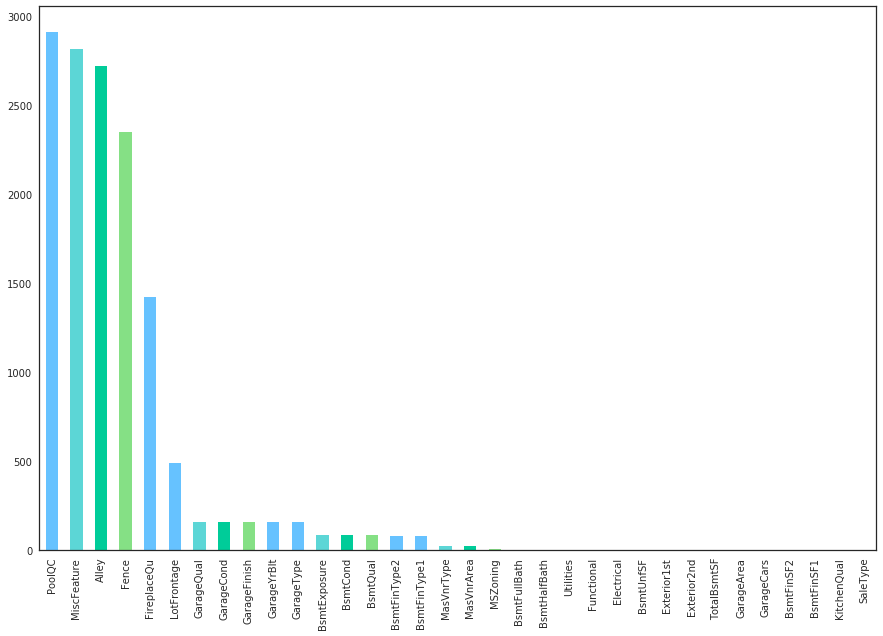

In [539]:
# aggregate all null values 
all_data_na = all_data.isnull().sum()

# get rid of all the values with 0 missing values
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(15, 10))
all_data_na.plot(kind='bar')

In [540]:
# Using data description, fill these missing values with "None"
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")
print("'None' - treated...")

# The area of the lot out front is likely to be similar to the houses in the local neighbourhood
# Therefore, let's use the median value of the houses in the neighbourhood to fill this feature
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
print("'LotFrontage' - treated...")

# Using data description, fill these missing values with 0 
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
print("'0' - treated...")


# Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
print("'mode' - treated...")
all_data = all_data.drop(['Utilities'], axis=1)
all_data_na = all_data.isnull().sum()
print("Features with missing values: ", len(all_data_na.drop(all_data_na[all_data_na == 0].index)))

'None' - treated...
'LotFrontage' - treated...
'0' - treated...
'mode' - treated...
Features with missing values:  0


# 4. 
## Exploratory Data Analysis

### 4.1 - Correlation matrix



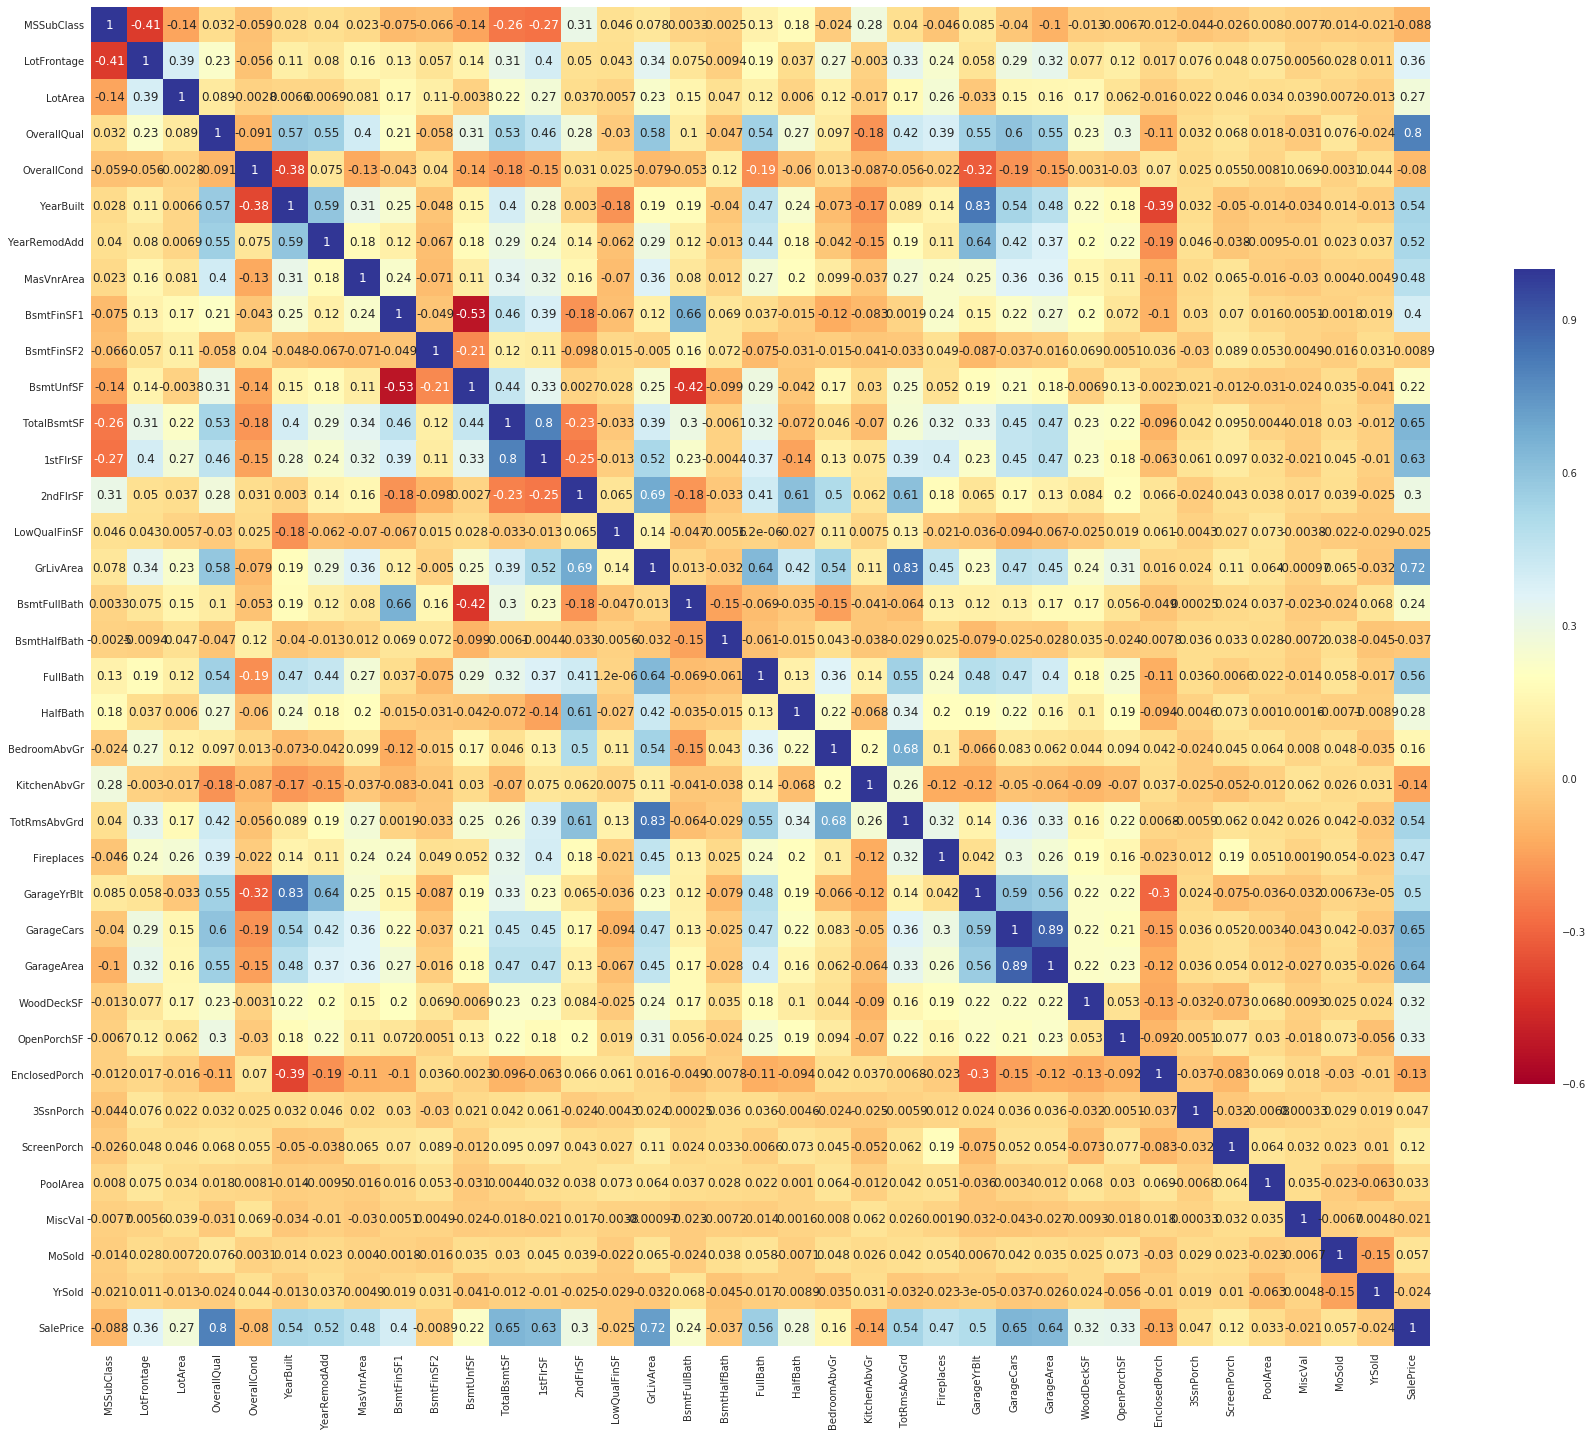

In [541]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

Using the correlation matrix, the top influencing factors that I will use to create polynomials are:
1. **OverallQual**
2. **GrLivArea**
3. **GarageCars**
4. **GarageArea**
5. **TotalBsmtSF**
6. **1stFlrSF**
7. **FullBath**
8. **TotRmsAbvGrd**
9. **Fireplaces**
10. **MasVnrArea**
11. **BsmtFinSF1**
12. **LotFrontage**
13. **WoodDeckSF**
14. **OpenPorchSF**
15. **2ndFlrSF**

In [542]:
# Quadratic
all_data["OverallQual-2"] = all_data["OverallQual"] ** 2
all_data["GrLivArea-2"] = all_data["GrLivArea"] ** 2
all_data["GarageCars-2"] = all_data["GarageCars"] ** 2
all_data["GarageArea-2"] = all_data["GarageArea"] ** 2
all_data["TotalBsmtSF-2"] = all_data["TotalBsmtSF"] ** 2
all_data["1stFlrSF-2"] = all_data["1stFlrSF"] ** 2
all_data["FullBath-2"] = all_data["FullBath"] ** 2
all_data["TotRmsAbvGrd-2"] = all_data["TotRmsAbvGrd"] ** 2
all_data["Fireplaces-2"] = all_data["Fireplaces"] ** 2
all_data["MasVnrArea-2"] = all_data["MasVnrArea"] ** 2
all_data["BsmtFinSF1-2"] = all_data["BsmtFinSF1"] ** 2
all_data["LotFrontage-2"] = all_data["LotFrontage"] ** 2
all_data["WoodDeckSF-2"] = all_data["WoodDeckSF"] ** 2
all_data["OpenPorchSF-2"] = all_data["OpenPorchSF"] ** 2
all_data["2ndFlrSF-2"] = all_data["2ndFlrSF"] ** 2
print("Quadratics done!...")

# Cubic
all_data["OverallQual-3"] = all_data["OverallQual"] ** 3
all_data["GrLivArea-3"] = all_data["GrLivArea"] ** 3
all_data["GarageCars-3"] = all_data["GarageCars"] ** 3
all_data["GarageArea-3"] = all_data["GarageArea"] ** 3
all_data["TotalBsmtSF-3"] = all_data["TotalBsmtSF"] ** 3
all_data["1stFlrSF-3"] = all_data["1stFlrSF"] ** 3
all_data["FullBath-3"] = all_data["FullBath"] ** 3
all_data["TotRmsAbvGrd-3"] = all_data["TotRmsAbvGrd"] ** 3
all_data["Fireplaces-3"] = all_data["Fireplaces"] ** 3
all_data["MasVnrArea-3"] = all_data["MasVnrArea"] ** 3
all_data["BsmtFinSF1-3"] = all_data["BsmtFinSF1"] ** 3
all_data["LotFrontage-3"] = all_data["LotFrontage"] ** 3
all_data["WoodDeckSF-3"] = all_data["WoodDeckSF"] ** 3
all_data["OpenPorchSF-3"] = all_data["OpenPorchSF"] ** 3
all_data["2ndFlrSF-3"] = all_data["2ndFlrSF"] ** 3
print("Cubics done!...")

# Square Root
all_data["OverallQual-Sq"] = np.sqrt(all_data["OverallQual"])
all_data["GrLivArea-Sq"] = np.sqrt(all_data["GrLivArea"])
all_data["GarageCars-Sq"] = np.sqrt(all_data["GarageCars"])
all_data["GarageArea-Sq"] = np.sqrt(all_data["GarageArea"])
all_data["TotalBsmtSF-Sq"] = np.sqrt(all_data["TotalBsmtSF"])
all_data["1stFlrSF-Sq"] = np.sqrt(all_data["1stFlrSF"])
all_data["FullBath-Sq"] = np.sqrt(all_data["FullBath"])
all_data["TotRmsAbvGrd-Sq"] = np.sqrt(all_data["TotRmsAbvGrd"])
all_data["Fireplaces-Sq"] = np.sqrt(all_data["Fireplaces"])
all_data["MasVnrArea-Sq"] = np.sqrt(all_data["MasVnrArea"])
all_data["BsmtFinSF1-Sq"] = np.sqrt(all_data["BsmtFinSF1"])
all_data["LotFrontage-Sq"] = np.sqrt(all_data["LotFrontage"])
all_data["WoodDeckSF-Sq"] = np.sqrt(all_data["WoodDeckSF"])
all_data["OpenPorchSF-Sq"] = np.sqrt(all_data["OpenPorchSF"])
all_data["2ndFlrSF-Sq"] = np.sqrt(all_data["2ndFlrSF"])
print("Roots done!...")

Quadratics done!...
Cubics done!...
Roots done!...


### 4.2 - Feature Engineering
Now that missing values and outliers have been treated, I will analyse the features based on the different aspects of the house available in the dataset to make these features more suitable to modeling.
This is quite lenghty, I borrowed the insight from another Kaggle project, which does a great job on feature engineering.

In [543]:
all_data['BsmtQual'] = all_data['BsmtQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['BsmtQual'].unique()

array([3, 2, 4, 0, 1])

In [544]:
all_data['BsmtCond'] = all_data['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['BsmtCond'].unique()

array([3, 4, 0, 2, 1])

In [545]:
all_data['BsmtExposure'] = all_data['BsmtExposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})
all_data['BsmtExposure'].unique()

array([1, 4, 2, 3, 0])

In [546]:
all_data = pd.get_dummies(all_data, columns = ["BsmtFinType1"], prefix="BsmtFinType1")
# all_data.head(3)

In [547]:
all_data['BsmtFinSF1_Band'] = pd.cut(all_data['BsmtFinSF1'], 4)
all_data['BsmtFinSF1_Band'].unique()

[(-4.01, 1002.5], (1002.5, 2005.0], (2005.0, 3007.5], (3007.5, 4010.0]]
Categories (4, interval[float64]): [(-4.01, 1002.5] < (1002.5, 2005.0] < (2005.0, 3007.5] < (3007.5, 4010.0]]

In [548]:
all_data.loc[all_data['BsmtFinSF1']<=1002.5, 'BsmtFinSF1'] = 1
all_data.loc[(all_data['BsmtFinSF1']>1002.5) & (all_data['BsmtFinSF1']<=2005), 'BsmtFinSF1'] = 2
all_data.loc[(all_data['BsmtFinSF1']>2005) & (all_data['BsmtFinSF1']<=3007.5), 'BsmtFinSF1'] = 3
all_data.loc[all_data['BsmtFinSF1']>3007.5, 'BsmtFinSF1'] = 4
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].astype(int)

all_data.drop('BsmtFinSF1_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["BsmtFinSF1"], prefix="BsmtFinSF1")
# all_data.head(3)

In [549]:
all_data = pd.get_dummies(all_data, columns = ["BsmtFinType2"], prefix="BsmtFinType2")
# all_data.head(3)

In [550]:
all_data['BsmtFinSf2_Flag'] = all_data['BsmtFinSF2'].map(lambda x:0 if x==0 else 1)
all_data.drop('BsmtFinSF2', axis=1, inplace=True)

In [551]:
all_data['BsmtUnfSF_Band'] = pd.cut(all_data['BsmtUnfSF'], 3)
all_data['BsmtUnfSF_Band'].unique()

[(-2.336, 778.667], (778.667, 1557.333], (1557.333, 2336.0]]
Categories (3, interval[float64]): [(-2.336, 778.667] < (778.667, 1557.333] < (1557.333, 2336.0]]

In [552]:
all_data.loc[all_data['BsmtUnfSF']<=778.667, 'BsmtUnfSF'] = 1
all_data.loc[(all_data['BsmtUnfSF']>778.667) & (all_data['BsmtUnfSF']<=1557.333), 'BsmtUnfSF'] = 2
all_data.loc[all_data['BsmtUnfSF']>1557.333, 'BsmtUnfSF'] = 3
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].astype(int)

all_data.drop('BsmtUnfSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["BsmtUnfSF"], prefix="BsmtUnfSF")
# all_data.head(3)

In [553]:
all_data['TotalBsmtSF_Band'] = pd.cut(all_data['TotalBsmtSF'], 10)
all_data['TotalBsmtSF_Band'].unique()

[(509.5, 1019.0], (1019.0, 1528.5], (1528.5, 2038.0], (-5.095, 509.5], (2038.0, 2547.5], (3057.0, 3566.5], (2547.5, 3057.0], (4585.5, 5095.0]]
Categories (8, interval[float64]): [(-5.095, 509.5] < (509.5, 1019.0] < (1019.0, 1528.5] < (1528.5, 2038.0] < (2038.0, 2547.5] < (2547.5, 3057.0] < (3057.0, 3566.5] < (4585.5, 5095.0]]

In [554]:
all_data.loc[all_data['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
all_data.loc[(all_data['TotalBsmtSF']>509.5) & (all_data['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
all_data.loc[(all_data['TotalBsmtSF']>1019) & (all_data['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
all_data.loc[(all_data['TotalBsmtSF']>1528.5) & (all_data['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
all_data.loc[(all_data['TotalBsmtSF']>2038) & (all_data['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
all_data.loc[(all_data['TotalBsmtSF']>2547.5) & (all_data['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
all_data.loc[(all_data['TotalBsmtSF']>3057) & (all_data['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
all_data.loc[all_data['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].astype(int)

all_data.drop('TotalBsmtSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")
# all_data.head(3)

In [555]:
all_data['1stFlrSF_Band'] = pd.cut(all_data['1stFlrSF'], 6)
all_data['1stFlrSF_Band'].unique()

[(329.239, 1127.5], (1127.5, 1921.0], (1921.0, 2714.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [556]:
all_data.loc[all_data['1stFlrSF']<=1127.5, '1stFlrSF'] = 1
all_data.loc[(all_data['1stFlrSF']>1127.5) & (all_data['1stFlrSF']<=1921), '1stFlrSF'] = 2
all_data.loc[(all_data['1stFlrSF']>1921) & (all_data['1stFlrSF']<=2714.5), '1stFlrSF'] = 3
all_data.loc[(all_data['1stFlrSF']>2714.5) & (all_data['1stFlrSF']<=3508), '1stFlrSF'] = 4
all_data.loc[(all_data['1stFlrSF']>3508) & (all_data['1stFlrSF']<=4301.5), '1stFlrSF'] = 5
all_data.loc[all_data['1stFlrSF']>4301.5, '1stFlrSF'] = 6
all_data['1stFlrSF'] = all_data['1stFlrSF'].astype(int)

all_data.drop('1stFlrSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["1stFlrSF"], prefix="1stFlrSF")
# all_data.head(3)

In [557]:
all_data['2ndFlrSF_Band'] = pd.cut(all_data['2ndFlrSF'], 6)
all_data['2ndFlrSF_Band'].unique()

[(620.667, 931.0], (-1.862, 310.333], (931.0, 1241.333], (310.333, 620.667], (1241.333, 1551.667], (1551.667, 1862.0]]
Categories (6, interval[float64]): [(-1.862, 310.333] < (310.333, 620.667] < (620.667, 931.0] < (931.0, 1241.333] < (1241.333, 1551.667] < (1551.667, 1862.0]]

In [558]:
all_data.loc[all_data['2ndFlrSF']<=310.333, '2ndFlrSF'] = 1
all_data.loc[(all_data['2ndFlrSF']>310.333) & (all_data['2ndFlrSF']<=620.667), '2ndFlrSF'] = 2
all_data.loc[(all_data['2ndFlrSF']>620.667) & (all_data['2ndFlrSF']<=931), '2ndFlrSF'] = 3
all_data.loc[(all_data['2ndFlrSF']>931) & (all_data['2ndFlrSF']<=1241.333), '2ndFlrSF'] = 4
all_data.loc[(all_data['2ndFlrSF']>1241.333) & (all_data['2ndFlrSF']<=1551.667), '2ndFlrSF'] = 5
all_data.loc[all_data['2ndFlrSF']>1551.667, '2ndFlrSF'] = 6
all_data['2ndFlrSF'] = all_data['2ndFlrSF'].astype(int)

all_data.drop('2ndFlrSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["2ndFlrSF"], prefix="2ndFlrSF")
# all_data.head(3)

In [559]:
all_data['LowQualFinSF_Flag'] = all_data['LowQualFinSF'].map(lambda x:0 if x==0 else 1)
all_data.drop('LowQualFinSF', axis=1, inplace=True)

In [560]:
all_data['TotalBathrooms'] = all_data['BsmtHalfBath'] + all_data['BsmtFullBath'] + all_data['HalfBath'] + all_data['FullBath']

columns = ['BsmtHalfBath', 'BsmtFullBath', 'HalfBath', 'FullBath']
all_data.drop(columns, axis=1, inplace=True)

In [561]:
all_data['KitchenQual'] = all_data['KitchenQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['KitchenQual'].unique()

array([3, 2, 4, 1])

In [562]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['FireplaceQu'].unique()

array([0, 3, 4, 2, 5, 1])

In [563]:
all_data['GrLivArea_Band'] = pd.cut(all_data['GrLivArea'], 6)
all_data['GrLivArea_Band'].unique()

[(1127.5, 1921.0], (1921.0, 2714.5], (329.239, 1127.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [564]:
all_data.loc[all_data['GrLivArea']<=1127.5, 'GrLivArea'] = 1
all_data.loc[(all_data['GrLivArea']>1127.5) & (all_data['GrLivArea']<=1921), 'GrLivArea'] = 2
all_data.loc[(all_data['GrLivArea']>1921) & (all_data['GrLivArea']<=2714.5), 'GrLivArea'] = 3
all_data.loc[(all_data['GrLivArea']>2714.5) & (all_data['GrLivArea']<=3508), 'GrLivArea'] = 4
all_data.loc[(all_data['GrLivArea']>3508) & (all_data['GrLivArea']<=4301.5), 'GrLivArea'] = 5
all_data.loc[all_data['GrLivArea']>4301.5, 'GrLivArea'] = 6
all_data['GrLivArea'] = all_data['GrLivArea'].astype(int)

all_data.drop('GrLivArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GrLivArea"], prefix="GrLivArea")
# all_data.head(3)

In [565]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["MSSubClass"], prefix="MSSubClass")
# all_data.head(3)

In [566]:
all_data['BldgType'] = all_data['BldgType'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["BldgType"], prefix="BldgType")
# all_data.head(3)

In [567]:
all_data['HouseStyle'] = all_data['HouseStyle'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})

all_data = pd.get_dummies(all_data, columns = ["HouseStyle"], prefix="HouseStyle")
# all_data.head(3)

In [568]:
all_data['Remod_Diff'] = all_data['YearRemodAdd'] - all_data['YearBuilt']

all_data.drop('YearRemodAdd', axis=1, inplace=True)

In [569]:
all_data['YearBuilt_Band'] = pd.cut(all_data['YearBuilt'], 7)
all_data['YearBuilt_Band'].unique()

[(1990.286, 2010.0], (1970.571, 1990.286], (1911.429, 1931.143], (1931.143, 1950.857], (1950.857, 1970.571], (1891.714, 1911.429], (1871.862, 1891.714]]
Categories (7, interval[float64]): [(1871.862, 1891.714] < (1891.714, 1911.429] < (1911.429, 1931.143] < (1931.143, 1950.857] < (1950.857, 1970.571] < (1970.571, 1990.286] < (1990.286, 2010.0]]

In [570]:
all_data.loc[all_data['YearBuilt']<=1892, 'YearBuilt'] = 1
all_data.loc[(all_data['YearBuilt']>1892) & (all_data['YearBuilt']<=1911), 'YearBuilt'] = 2
all_data.loc[(all_data['YearBuilt']>1911) & (all_data['YearBuilt']<=1931), 'YearBuilt'] = 3
all_data.loc[(all_data['YearBuilt']>1931) & (all_data['YearBuilt']<=1951), 'YearBuilt'] = 4
all_data.loc[(all_data['YearBuilt']>1951) & (all_data['YearBuilt']<=1971), 'YearBuilt'] = 5
all_data.loc[(all_data['YearBuilt']>1971) & (all_data['YearBuilt']<=1990), 'YearBuilt'] = 6
all_data.loc[all_data['YearBuilt']>1990, 'YearBuilt'] = 7
all_data['YearBuilt'] = all_data['YearBuilt'].astype(int)

all_data.drop('YearBuilt_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["YearBuilt"], prefix="YearBuilt")
# all_data.head(3)

In [571]:
all_data = pd.get_dummies(all_data, columns = ["Foundation"], prefix="Foundation")
# all_data.head(3)

In [572]:
all_data['Functional'] = all_data['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})
all_data['Functional'].unique()

array([7, 6, 3, 5, 4, 2, 1])

In [573]:
all_data = pd.get_dummies(all_data, columns = ["RoofStyle"], prefix="RoofStyle")
# all_data.head(3)

In [574]:
all_data = pd.get_dummies(all_data, columns = ["RoofMatl"], prefix="RoofMatl")
# all_data.head(3)

In [575]:
def Exter2(col):
    if col['Exterior2nd'] == col['Exterior1st']:
        return 1
    else:
        return 0
    
all_data['ExteriorMatch_Flag'] = all_data.apply(Exter2, axis=1)
all_data.drop('Exterior2nd', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Exterior1st"], prefix="Exterior1st")
# all_data.head(3)

In [576]:
all_data = pd.get_dummies(all_data, columns = ["MasVnrType"], prefix="MasVnrType")
# all_data.head(3)

In [577]:
all_data.drop('MasVnrArea', axis=1, inplace=True)

In [578]:
all_data['ExterQual'] = all_data['ExterQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['ExterQual'].unique()

array([3, 2, 4, 1])

In [579]:
all_data = pd.get_dummies(all_data, columns = ["ExterCond"], prefix="ExterCond")
# all_data.head(3)

In [580]:
all_data = pd.get_dummies(all_data, columns = ["GarageType"], prefix="GarageType")
# all_data.head(3)

In [581]:
all_data['GarageYrBlt_Band'] = pd.qcut(all_data['GarageYrBlt'], 3)
all_data['GarageYrBlt_Band'].unique()

[(1996.0, 2207.0], (1964.0, 1996.0], (-0.001, 1964.0]]
Categories (3, interval[float64]): [(-0.001, 1964.0] < (1964.0, 1996.0] < (1996.0, 2207.0]]

In [582]:
all_data.loc[all_data['GarageYrBlt']<=1964, 'GarageYrBlt'] = 1
all_data.loc[(all_data['GarageYrBlt']>1964) & (all_data['GarageYrBlt']<=1996), 'GarageYrBlt'] = 2
all_data.loc[all_data['GarageYrBlt']>1996, 'GarageYrBlt'] = 3
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(int)

all_data.drop('GarageYrBlt_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GarageYrBlt"], prefix="GarageYrBlt")
# all_data.head(3)

In [583]:
all_data = pd.get_dummies(all_data, columns = ["GarageFinish"], prefix="GarageFinish")
# all_data.head(3)

In [584]:
all_data['GarageArea_Band'] = pd.cut(all_data['GarageArea'], 3)
all_data['GarageArea_Band'].unique()

[(496.0, 992.0], (-1.488, 496.0], (992.0, 1488.0]]
Categories (3, interval[float64]): [(-1.488, 496.0] < (496.0, 992.0] < (992.0, 1488.0]]

In [585]:
all_data.loc[all_data['GarageArea']<=496, 'GarageArea'] = 1
all_data.loc[(all_data['GarageArea']>496) & (all_data['GarageArea']<=992), 'GarageArea'] = 2
all_data.loc[all_data['GarageArea']>992, 'GarageArea'] = 3
all_data['GarageArea'] = all_data['GarageArea'].astype(int)

all_data.drop('GarageArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GarageArea"], prefix="GarageArea")
# all_data.head(3)

In [586]:
all_data['GarageQual'] = all_data['GarageQual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageQual'].unique()

array(['TA', 'Low', 'High', 'None'], dtype=object)

In [587]:
all_data = pd.get_dummies(all_data, columns = ["GarageQual"], prefix="GarageQual")
# all_data.head(3)

In [588]:
all_data['GarageCond'] = all_data['GarageCond'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageCond'].unique()

array(['TA', 'Low', 'None', 'High'], dtype=object)

In [589]:
all_data = pd.get_dummies(all_data, columns = ["GarageCond"], prefix="GarageCond")
# all_data.head(3)

In [590]:
def WoodDeckFlag(col):
    if col['WoodDeckSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoWoodDeck_Flag'] = all_data.apply(WoodDeckFlag, axis=1)

all_data['WoodDeckSF_Band'] = pd.cut(all_data['WoodDeckSF'], 4)

all_data.loc[all_data['WoodDeckSF']<=356, 'WoodDeckSF'] = 1
all_data.loc[(all_data['WoodDeckSF']>356) & (all_data['WoodDeckSF']<=712), 'WoodDeckSF'] = 2
all_data.loc[(all_data['WoodDeckSF']>712) & (all_data['WoodDeckSF']<=1068), 'WoodDeckSF'] = 3
all_data.loc[all_data['WoodDeckSF']>1068, 'WoodDeckSF'] = 4
all_data['WoodDeckSF'] = all_data['WoodDeckSF'].astype(int)

all_data.drop('WoodDeckSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["WoodDeckSF"], prefix="WoodDeckSF")
# all_data.head(3)

In [591]:
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

In [592]:
def PorchFlag(col):
    if col['TotalPorchSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoPorch_Flag'] = all_data.apply(PorchFlag, axis=1)

all_data['TotalPorchSF_Band'] = pd.cut(all_data['TotalPorchSF'], 4)
all_data['TotalPorchSF_Band'].unique()

[(-1.724, 431.0], (431.0, 862.0], (862.0, 1293.0], (1293.0, 1724.0]]
Categories (4, interval[float64]): [(-1.724, 431.0] < (431.0, 862.0] < (862.0, 1293.0] < (1293.0, 1724.0]]

In [593]:
all_data.loc[all_data['TotalPorchSF']<=431, 'TotalPorchSF'] = 1
all_data.loc[(all_data['TotalPorchSF']>431) & (all_data['TotalPorchSF']<=862), 'TotalPorchSF'] = 2
all_data.loc[(all_data['TotalPorchSF']>862) & (all_data['TotalPorchSF']<=1293), 'TotalPorchSF'] = 3
all_data.loc[all_data['TotalPorchSF']>1293, 'TotalPorchSF'] = 4
all_data['TotalPorchSF'] = all_data['TotalPorchSF'].astype(int)

all_data.drop('TotalPorchSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalPorchSF"], prefix="TotalPorchSF")
# all_data.head(3)

In [594]:
def PoolFlag(col):
    if col['PoolArea'] == 0:
        return 0
    else:
        return 1
    
all_data['HasPool_Flag'] = all_data.apply(PoolFlag, axis=1)
all_data.drop('PoolArea', axis=1, inplace=True)

In [595]:
all_data.drop('PoolQC', axis=1, inplace=True)

In [596]:
all_data = pd.get_dummies(all_data, columns = ["Fence"], prefix="Fence")
# all_data.head(3)

In [597]:
all_data = pd.get_dummies(all_data, columns = ["MSZoning"], prefix="MSZoning")
# all_data.head(3)

In [598]:
all_data = pd.get_dummies(all_data, columns = ["Neighborhood"], prefix="Neighborhood")
# all_data.head(3)

In [599]:
all_data['Condition1'] = all_data['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
all_data['Condition2'] = all_data['Condition2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})

In [600]:
def ConditionMatch(col):
    if col['Condition1'] == col['Condition2']:
        return 0
    else:
        return 1
    
all_data['Diff2ndCondition_Flag'] = all_data.apply(ConditionMatch, axis=1)
all_data.drop('Condition2', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Condition1"], prefix="Condition1")
# all_data.head(3)

In [601]:
all_data['LotArea_Band'] = pd.qcut(all_data['LotArea'], 8)
all_data['LotArea_Band'].unique()

[(7474.0, 8520.0], (9450.0, 10355.25], (10355.25, 11554.5], (13613.0, 215245.0], (5684.75, 7474.0], (11554.5, 13613.0], (1299.999, 5684.75], (8520.0, 9450.0]]
Categories (8, interval[float64]): [(1299.999, 5684.75] < (5684.75, 7474.0] < (7474.0, 8520.0] < (8520.0, 9450.0] < (9450.0, 10355.25] < (10355.25, 11554.5] < (11554.5, 13613.0] < (13613.0, 215245.0]]

In [602]:
all_data.loc[all_data['LotArea']<=5684.75, 'LotArea'] = 1
all_data.loc[(all_data['LotArea']>5684.75) & (all_data['LotArea']<=7474), 'LotArea'] = 2
all_data.loc[(all_data['LotArea']>7474) & (all_data['LotArea']<=8520), 'LotArea'] = 3
all_data.loc[(all_data['LotArea']>8520) & (all_data['LotArea']<=9450), 'LotArea'] = 4
all_data.loc[(all_data['LotArea']>9450) & (all_data['LotArea']<=10355.25), 'LotArea'] = 5
all_data.loc[(all_data['LotArea']>10355.25) & (all_data['LotArea']<=11554.25), 'LotArea'] = 6
all_data.loc[(all_data['LotArea']>11554.25) & (all_data['LotArea']<=13613), 'LotArea'] = 7
all_data.loc[all_data['LotArea']>13613, 'LotArea'] = 8
all_data['LotArea'] = all_data['LotArea'].astype(int)

all_data.drop('LotArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["LotArea"], prefix="LotArea")
# all_data.head(3)

In [603]:
all_data = pd.get_dummies(all_data, columns = ["LotShape"], prefix="LotShape")
# all_data.head(3)

In [604]:
all_data = pd.get_dummies(all_data, columns = ["LandContour"], prefix="LandContour")
# all_data.head(3)

In [605]:
all_data['LotConfig'] = all_data['LotConfig'].map({"Inside":"Inside", "FR2":"FR", "Corner":"Corner", "CulDSac":"CulDSac", "FR3":"FR"})

all_data = pd.get_dummies(all_data, columns = ["LotConfig"], prefix="LotConfig")
all_data.head(3)

,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtQual,CentralAir,Electrical,EnclosedPorch,ExterQual,FireplaceQu,Fireplaces,Functional,GarageCars,Heating,HeatingQC,KitchenAbvGr,KitchenQual,LandSlope,LotFrontage,MiscFeature,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PavedDrive,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,YrSold,OverallQual-2,GrLivArea-2,GarageCars-2,GarageArea-2,TotalBsmtSF-2,1stFlrSF-2,FullBath-2,...,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Diff2ndCondition_Flag,Condition1_Norm,Condition1_Pos,Condition1_Street,Condition1_Train,LotArea_1,LotArea_2,LotArea_3,LotArea_4,LotArea_5,LotArea_6,LotArea_7,LotArea_8,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR,LotConfig_Inside
0,0,None,3,3,1,3,Y,SBrkr,0,3,0,0,7,2.0,GasA,Ex,1,3,Gtl,65.0,None,0,2,61,5,7,Y,Normal,WD,0,Pave,8,2008,49,2924100,4.0,300304.0,732736.0,732736,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,0,None,3,3,4,3,Y,SBrkr,0,2,3,1,7,2.0,GasA,Ex,1,2,Gtl,80.0,None,0,5,0,8,6,Y,Normal,WD,0,Pave,6,2007,36,1592644,4.0,211600.0,1592644.0,1592644,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,0,None,3,3,2,3,Y,SBrkr,0,3,3,1,7,2.0,GasA,Ex,1,3,Gtl,68.0,None,0,9,42,5,7,Y,Normal,WD,0,Pave,6,2008,49,3189796,4.0,369664.0,846400.0,846400,4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [606]:
all_data['LandSlope'] = all_data['LandSlope'].map({"Gtl":1, "Mod":2, "Sev":2})

In [607]:
def Slope(col):
    if col['LandSlope'] == 1:
        return 1
    else:
        return 0
    
all_data['GentleSlope_Flag'] = all_data.apply(Slope, axis=1)
all_data.drop('LandSlope', axis=1, inplace=True)

In [608]:
all_data.drop('Street', axis=1, inplace=True)

In [609]:
all_data = pd.get_dummies(all_data, columns = ["Alley"], prefix="Alley")
# all_data.head(3)

In [610]:
all_data = pd.get_dummies(all_data, columns = ["PavedDrive"], prefix="PavedDrive")
# all_data.head(3)

In [611]:
all_data['GasA_Flag'] = all_data['Heating'].map({"GasA":1, "GasW":0, "Grav":0, "Wall":0, "OthW":0, "Floor":0})
all_data.drop('Heating', axis=1, inplace=True)
# all_data.head(3)

In [612]:
all_data['HeatingQC'] = all_data['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['HeatingQC'].unique()

array([5, 4, 3, 2, 1])

In [613]:
all_data['CentralAir'] = all_data['CentralAir'].map({"Y":1, "N":0})
all_data['CentralAir'].unique()

array([1, 0])

In [614]:
all_data['Electrical'] = all_data['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})

all_data = pd.get_dummies(all_data, columns = ["Electrical"], prefix="Electrical")
# all_data.head(3)

In [615]:
columns=['MiscFeature', 'MiscVal']
all_data.drop(columns, axis=1, inplace=True)

In [616]:
all_data = pd.get_dummies(all_data, columns = ["MoSold"], prefix="MoSold")
# all_data.head(3)

In [617]:
all_data = pd.get_dummies(all_data, columns = ["YrSold"], prefix="YrSold")
# all_data.head(3)

In [618]:
all_data['SaleType'] = all_data['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
                                                 "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})

all_data = pd.get_dummies(all_data, columns = ["SaleType"], prefix="SaleType")
# all_data.head(3)

In [619]:
all_data = pd.get_dummies(all_data, columns = ["SaleCondition"], prefix="SaleCondition")
# all_data.head(3)

In [620]:
# all_data.to_csv('preprocessed_data.csv',index=False)
# all_data = pd.read_csv('preprocessed_data.csv')

### 4.3 - Target Variable

> - It is always useful to check the distribution of the target variable, and indeed all numeric variables, when building a regression model. Machine Learning algorithms work well with features that are **normally distributed**, a distribution that is symmetric and has a characteristic bell shape. If features are not normally distributed, you can transform them using clever statistical methods.

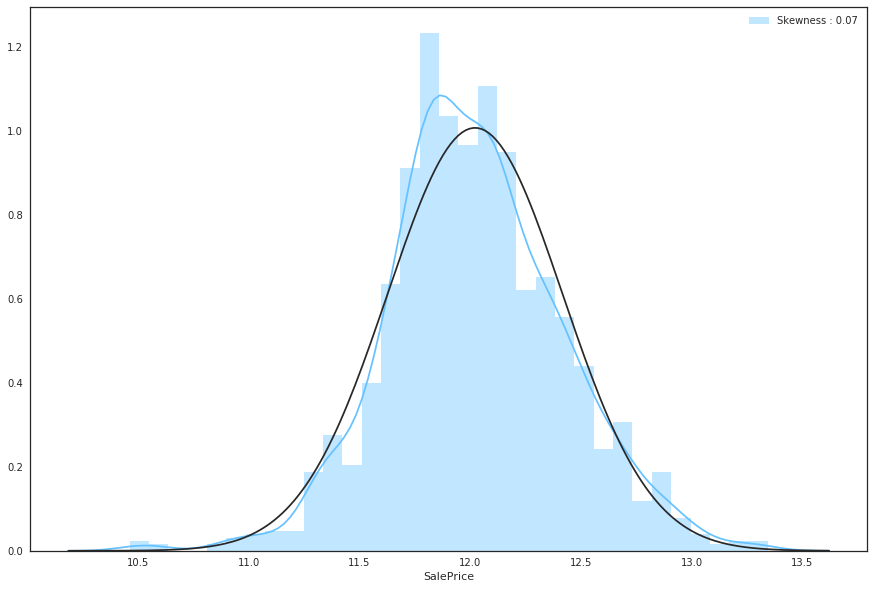

In [621]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train["SalePrice"]

#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")


### 4.4 - Treating skewed features

> As touched on earlier, skewed numeric variables are not desirable when using Machine Learning algorithms. We can make them normalized by transforming skewed features.

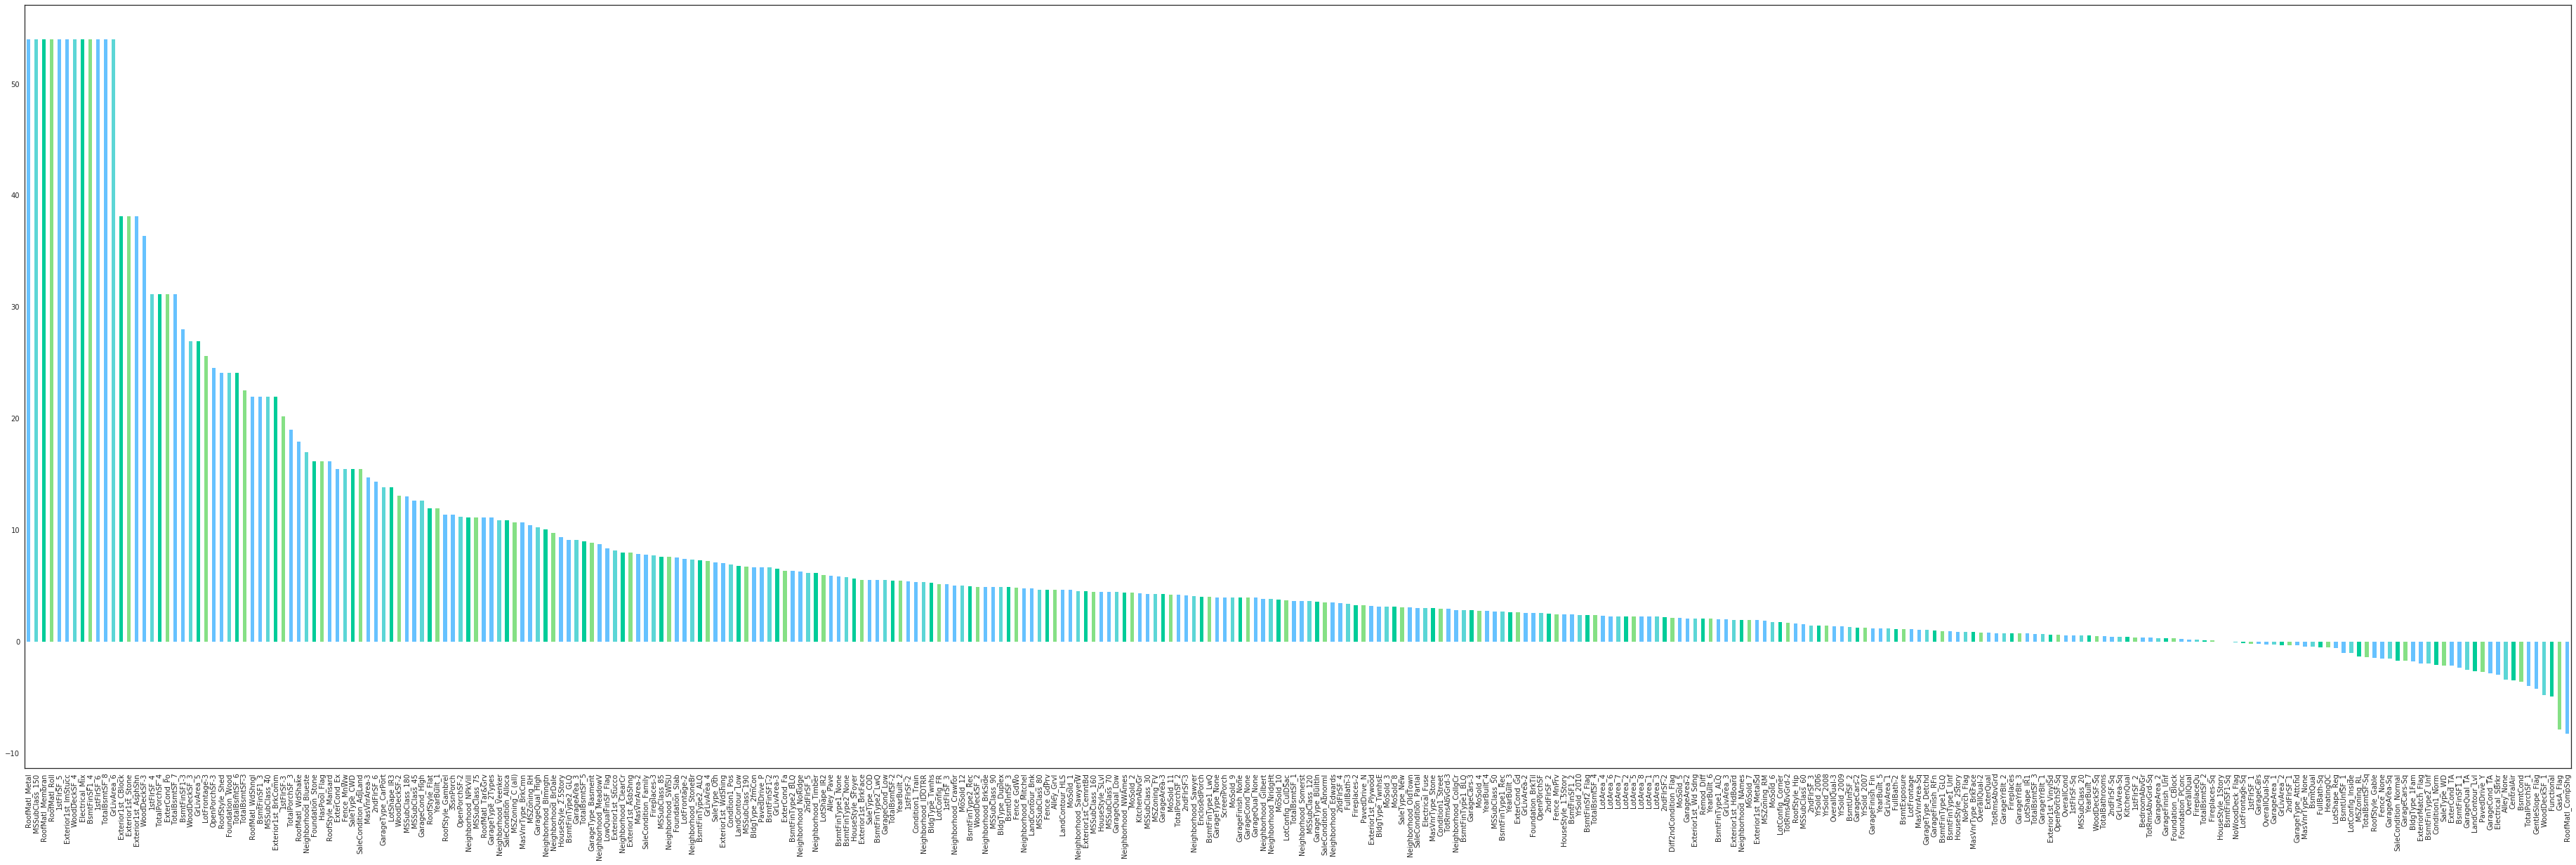

In [622]:
# First lets single out the numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check how skewed they are
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize =(65, 20))
skewed_feats.plot(kind='bar');

In [623]:
skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

302 skewed numerical features have been Box-Cox transformed



# 5. 
## Modeling


### 5.1 - Preparation of data

- Now that our dataset is ready for modeling, we must prepare it from training, testing and prediction. One of the vital steps here is to reduce the number of features. I will do this using XGBoost's inbuilt feature importance functionality.

In [624]:
# First, re-create the training and test datasets
train = all_data[:ntrain]
test = all_data[ntrain:]

print(train.shape)
print(test.shape)

(1456, 330)
(1459, 330)


In [625]:
xgb_train = train.copy()
xgb_test = test.copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)

# Allow the feature importances attribute to select the most important features
xgb_feat_red = SelectFromModel(model, prefit = True)

# Reduce estimation, validation and test datasets
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (1456, 71) 
X_test:  (1459, 71)


In [626]:
# Next we want to sample our training data to test for performance of robustness and accuracy, before applying to the test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, y_train, test_size=0.3, random_state=42)

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (1019, 71) 
X_test:  (437, 71) 
Y_train:  (1019,) 
Y_test:  (437,)



### 5.2 - Training

We are finally ready to train our models. For this analysis I am using 8 different algorithms:
- **Kernel Ridge Regression**
- **Elastic Net**
- **Lasso**
- **Gradient Boosting**
- **Bayesian Ridge**
- **Lasso Lars IC**
- **Random Forest Regressor**
- **XGBoost**

The method of measuring accuracy was chosen to be **Root Mean Squared Error**.

In [627]:
import xgboost as xgb
#Machine Learning Algorithm Selection and Initialization
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, Y_train)
    
    #score model with cross validation
    training_results = np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...",30.763,32.917
1,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",22.081,22.351
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",27.211,27.333
3,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",12.276,12.422
4,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",11.229,11.759
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 2....",12.552,12.511
6,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",14.538,14.750
7,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",12.542,12.421


- We can see that each of the models performs with varying ability, with **Bayesian Ridge** having the best accuracy score on the training dataset and accuracy on the validation dataset.


### 5.3 - Optimization

- As you can see from the above table, the accuracy for these models is not quite as good as it could be.
- This is because we use the default configuration of parameters for each of the algorithms.

So now, we will use **GridSearchCV** to find the best combinations of parameters to produce the highest scoring models. To save time and computation, I will use some best practiced parameters here.

In [628]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare
# In this case, we can see that after optimization, LASSO can get the best training accuracy and test accuracy among those 8 algorithms.
# So, we will firstly use optimized LASSO to predict the test data set. Later, we will compare it with the final prediction result
# to see the performance improvement by stacking and ensembling.


gs_alg = GridSearchCV(Lasso(), param_grid = LASS_param_grid, cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
gs_alg.fit(xgb_train,y_train)
comparison_Lasso = gs_alg.predict(xgb_test)
submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = comparison_Lasso
submission.to_csv('Lasso_submission.csv',index=False)

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...



### 5.4 - Stacking

Now that we have a set of highly tuned algorithms, a rather famous and successful technique to further improve the accuracy of these models, is to use **Stacking**.

- Before I start with the stacking, I need to decide which algorithms to use as my base estimators, and which to use as the meta-model.

- Since **Lasso** performed the best after optimisation, I chose this to be the **meta-model**. All other models will be used as base estimators.

- So now, I will cycle through each optimised estimator, train them on the training dataset, apply to them the validation and test datasets, then finally outputting the predictions for validation and test into two new datasets: **stacked_validation_train** and **stacked_test_train**.

In [531]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = gs_best.predict(xgb_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------
2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------
3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------
6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added

In [532]:
# First drop the Lasso results from the table, as we will be using Lasso as the meta-model
drop = ['Lasso']
stacked_validation_train.drop(drop, axis=1, inplace=True)
stacked_test_train.drop(drop, axis=1, inplace=True)

# Now fit the meta model and generate predictions
meta_model = make_pipeline(RobustScaler(), Lasso(alpha=0.00001, copy_X = True, fit_intercept = True,
                                              normalize = False, precompute = False, max_iter = 10000,
                                              tol = 0.0001, selection = 'random', random_state = None))
meta_model.fit(stacked_validation_train, Y_test)

meta_model_pred = np.expm1(meta_model.predict(stacked_test_train))
print("Meta-model trained and applied!...")

Meta-model trained and applied!...



### 5.5 - Ensemble

- Using the meta-model that I will create, I will also combine this with the results of the individual optimised models to create an ensemble.

In [533]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(stacked_validation_train, Y_test)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = names[0], value = np.expm1(gs_best.predict(stacked_test_train)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...
4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...
6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
Done


,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,121777.672517,121924.373067,119744.309159,125630.427818,122951.444487,121515.054045,120864.431363,115562.078125
1,164254.405352,163936.991253,165749.328525,154525.172757,164648.364021,163883.091906,158933.317205,155140.093750
2,183765.156988,183822.413685,183475.415534,180303.680190,185287.480025,183910.827116,185620.615512,169210.906250
3,196733.353380,196316.726763,197029.406094,183644.164332,198393.540267,196829.122250,183478.779203,191859.000000
4,182071.236857,181723.196635,183566.148745,184145.596711,179925.151068,180849.644430,177820.080574,189535.906250



### 5.6 - Submission

In [534]:
ensemble = meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(1/10) + final_predictions['Lasso']*(1/10) + final_predictions['KernelRidge']*(1/10) + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['Random Forest']*(1.5/10)

submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ensemble
submission.to_csv('final_submission.csv',index=False)
print("Submission file, created!")

Submission file, created!
